In [1]:
!pip install nmrglue
!pip install peakutils
!pip install scikit-ued
from sys import path_hooks
import pathlib as pth
import numpy as np
import nmrglue as ng
from matplotlib import pyplot as plt
import pandas as pd
from peakutils import baseline
import os
import skued

In [2]:
class SpectraSequence:
    def __init__(self, file_path, sequence, order, apply_mask=True):
        self.file_path = file_path
        self.df = pd.read_csv(os.path.join(self.file_path, 'dict.csv'))
        self.sequence = list(sequence)
        self.data = []
        self.dic = []
        self.peak_width = []
        self.center = []
        self.region = []
        self.at = []
        self.phases = []
        self.spectras = []
        self.freqs = []
        self.id = {'noize_idx': [], 'im_idx': [], 're_idx': []}
        self.areas = []
        self.read_files()
        self.size = [len(self.sequence), len(self.data[0]), [len(self.data[i][0]) for i in range(len(self.data))]]
        self.proper_phases()
        self.perform_fourier()
        self.spectras, self.freqs = self.apply_mask(apply_mask)
        self.noize_spectra_idx()
        self.identify()

    def read_files(self):
        for seq in self.sequence:
            tmp = os.path.join(self.file_path, seq)
            d, da = ng.varian.read(tmp)
            self.data.append(da)
            self.dic.append(d)
            self.at.append(float(d['procpar']['at']['values'][0]))
            filtered_df = self.df[self.df['nucleus'] == seq]
            if filtered_df.empty:
                raise TypeError(f"Проверьте файл dict.csv для {seq}")
            self.peak_width.append(filtered_df['peak_width'].values[0])
            self.center.append(filtered_df['center'].values[0])
            self.region.append(filtered_df['borders'].values[0])

    def proper_phases(self):
        for i in range(self.size[0]):
            spectrum_unpr = np.fft.fft(self.data[i][0])
            spectrum, phase = ng.proc_autophase.autops(spectrum_unpr, 'acme', return_phases=True)
            self.phases.append(phase)

    def noize_spectra_idx(self):
        if not self.spectras:
            raise ValueError('Сначала выполните Фурье: .perform_fourier()')

        thresholds = [np.mean([max(np.real(spec)) for spec in spectra]) / 2 for spectra in self.spectras]

        noise_indices = [
            [idx for idx, max_val in enumerate([max(np.real(spec)) for spec in spectra]) if max_val < thresholds[i]]
            for i, spectra in enumerate(self.spectras)
        ]

        for indices in noise_indices:
            if len(indices) != 9:
                raise ValueError('Спектр нечеткий, подберите threshold для корректной работы.')

        return noise_indices


    def identify(self):
        if len(self.size) == 0:
            raise ValueError('Сначала выполните фурье .perform_fourier()')
        tmp = self.noize_spectra_idx()
        for i in range(self.size[0]):
            n_i = tmp[i]
            i_i = []
            r_i = []
            for j in range(self.size[1]-1):
                spec = self.spectras[i][j+1]
                spec_re = ((np.real(spec) / max(abs(np.real(spec))))*3)
                spec_im = ((np.imag(spec) / max(abs(np.imag(spec))))*3)
                if j+1 not in n_i and np.std(spec_re) > np.std(spec_im):
                    i_i.append(j+1)
                elif j+1 not in n_i and np.std(spec_re) < np.std(spec_im):
                    r_i.append(j+1)
            self.id['noize_idx'].append(n_i)
            self.id['im_idx'].append(i_i)
            self.id['re_idx'].append(r_i)


    def perform_fourier(self, apply_mask = True):
        if len(self.phases) == 0:
            raise ValueError('Перед выполнением фурье выполните коррекцию фазы (метод proper_phases())')
        for i in range(self.size[0]):
            freq = np.fft.fftfreq(len(self.data[i][0]), self.at[i] / len(self.data[i][0]))
            self.freqs.append(freq)
            spec_set = []
            for j in range(self.size[1]):
                spectrum = np.fft.fft(self.data[i][j]) * np.exp(1j * 2 * np.pi / 360 * (self.phases[i][0]))
                spec_set.append(spectrum)
            self.spectras.append(spec_set)


    def prepare_spectras(self, k):
        p_s = []
        for i in range(self.size[0]):
            t = []
            for j in range(self.size[1]):
                if j in self.id['im_idx'][i]:
                    corr = (-np.imag(self.spectras[i][j]) / max(-np.imag(self.spectras[i][j])) * k)**5
                    t.append(corr / max(corr))
                elif j in self.id['re_idx'][i]:
                    corr = (np.real(self.spectras[i][j]) / max(np.real(self.spectras[i][j])) * k)**5
                    t.append(corr/max(corr))
                else:
                    t.append(self.spectras[i][j] / max(self.spectras[i][j]))
            p_s.append(t)
        return p_s

    def locate_peaks(self, k):
        p_s = self.prepare_spectras(k)
        peaks = []
        for i in range(self.size[0]):
            peaks_set = []
            for j in range(self.size[1]):
                peaks_subset = []
                if j not in self.id['noize_idx'][i] and j != 0:
                    loc_peaks = ng.analysis.peakpick.pick(p_s[i][j], 0.05, -0.2)
                    for k in range(len(loc_peaks)):
                        peaks_subset.append(int(loc_peaks[k][0]))
                else: peaks_subset.append(None)
                peaks_set.append(peaks_subset)
            peaks.append(peaks_set)
        return peaks


    def correct_baselines(self, iter):
        for i in range(self.size[0]):
            for j in self.id['re_idx'][i]:
                bl = skued.baseline_dwt(self.spectras[i][j], iter)
                self.spectras[i][j] -= bl


    def apply_mask(self, apply_mask):
        spectras = []
        frequencies = []
        for freq, spectrum_set, center, region in zip(self.freqs, self.spectras, self.center, self.region):
            if apply_mask:
                mask = (freq >= center - region) & (freq <= center + region)
                frequencies.append(freq[mask])
                spectras.append([spectrum[mask] for spectrum in spectrum_set])
            else:
                frequencies.append(freq)
                spectras.append(spectrum_set)
        return spectras, frequencies

    def calculate_areas(self, peaks):
        for i, freq_set in enumerate(self.freqs):
            areas = []
            dnu = freq_set[1] - freq_set[0]
            for j, spectrum in enumerate(self.spectras[i]):
                areas_ss = 0
                for peak in peaks[i][j]:
                    if peak is not None:
                        left, right = peak - int(self.peak_width[i] / dnu), peak + int(self.peak_width[i] / dnu)
                        areas_ss += np.trapz(np.real(spectrum[left:right]), freq_set[left:right])
                areas.append(areas_ss)
            self.areas.append(areas)
        return self.areas


    def plot(self):
      k=True


In [3]:
order = [
    "11x", "11y", "1xx", "1xy", "1yx", "1yy", "x1x", "x1y", "xxx", "xxy",
    "xyx", "xyy", "y1x", "y1y", "yxx", "yxy", "yyx", "yyy", "111", "1x1",
    "1y1", "x11", "xx1", "xy1", "y11", "yx1", "yy1"
]
iter = 1
ss = SpectraSequence(r'test', 'HCN', order, apply_mask=True);
ss.correct_baselines(iter)
peaks = ss.locate_peaks(k=3)
print(ss.calculate_areas(peaks))
for i in range(ss.size[0]):
  print(len(ss.id['im_idx'][i]), len(ss.id['re_idx'][i]), len(ss.id['noize_idx'][i]))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 132
         Function evaluations: 246
Optimization terminated successfully.
         Current function value: 1062.591951
         Iterations: 96
         Function evaluations: 182
Optimization terminated successfully.
         Current function value: 7195.347037
         Iterations: 114
         Function evaluations: 220
[[0, 0, 0, 0, 0, 0, 0, 157769.809664241, 157781.18843507714, 221172.4834803366, 154564.84687304002, 219201.93174334988, 156385.32015592378, 6962.221802928918, 23642.685493936646, 19696.415198188108, 11990.993416344583, 8337.133198798558, 24419.17646484154, 0, 0, 0, 156273.40738421318, 160641.7839300727, 155415.96196794015, 20045.22291750798, 29065.006409021127, 19250.53093156094], [0, 0, 0, 15845.233453439172, 15574.64474704305, 4675.16223433066, 5024.389846621042, 0, 0, 15862.279939360124, 15629.775629566904, 5817.967895613223, 5078.837031930391, 0, 0, 15620.308810061

/usr/local/lib/python3.10/dist-packages/skued/baseline/algorithms.py:195: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.asarray(array, dtype=float)


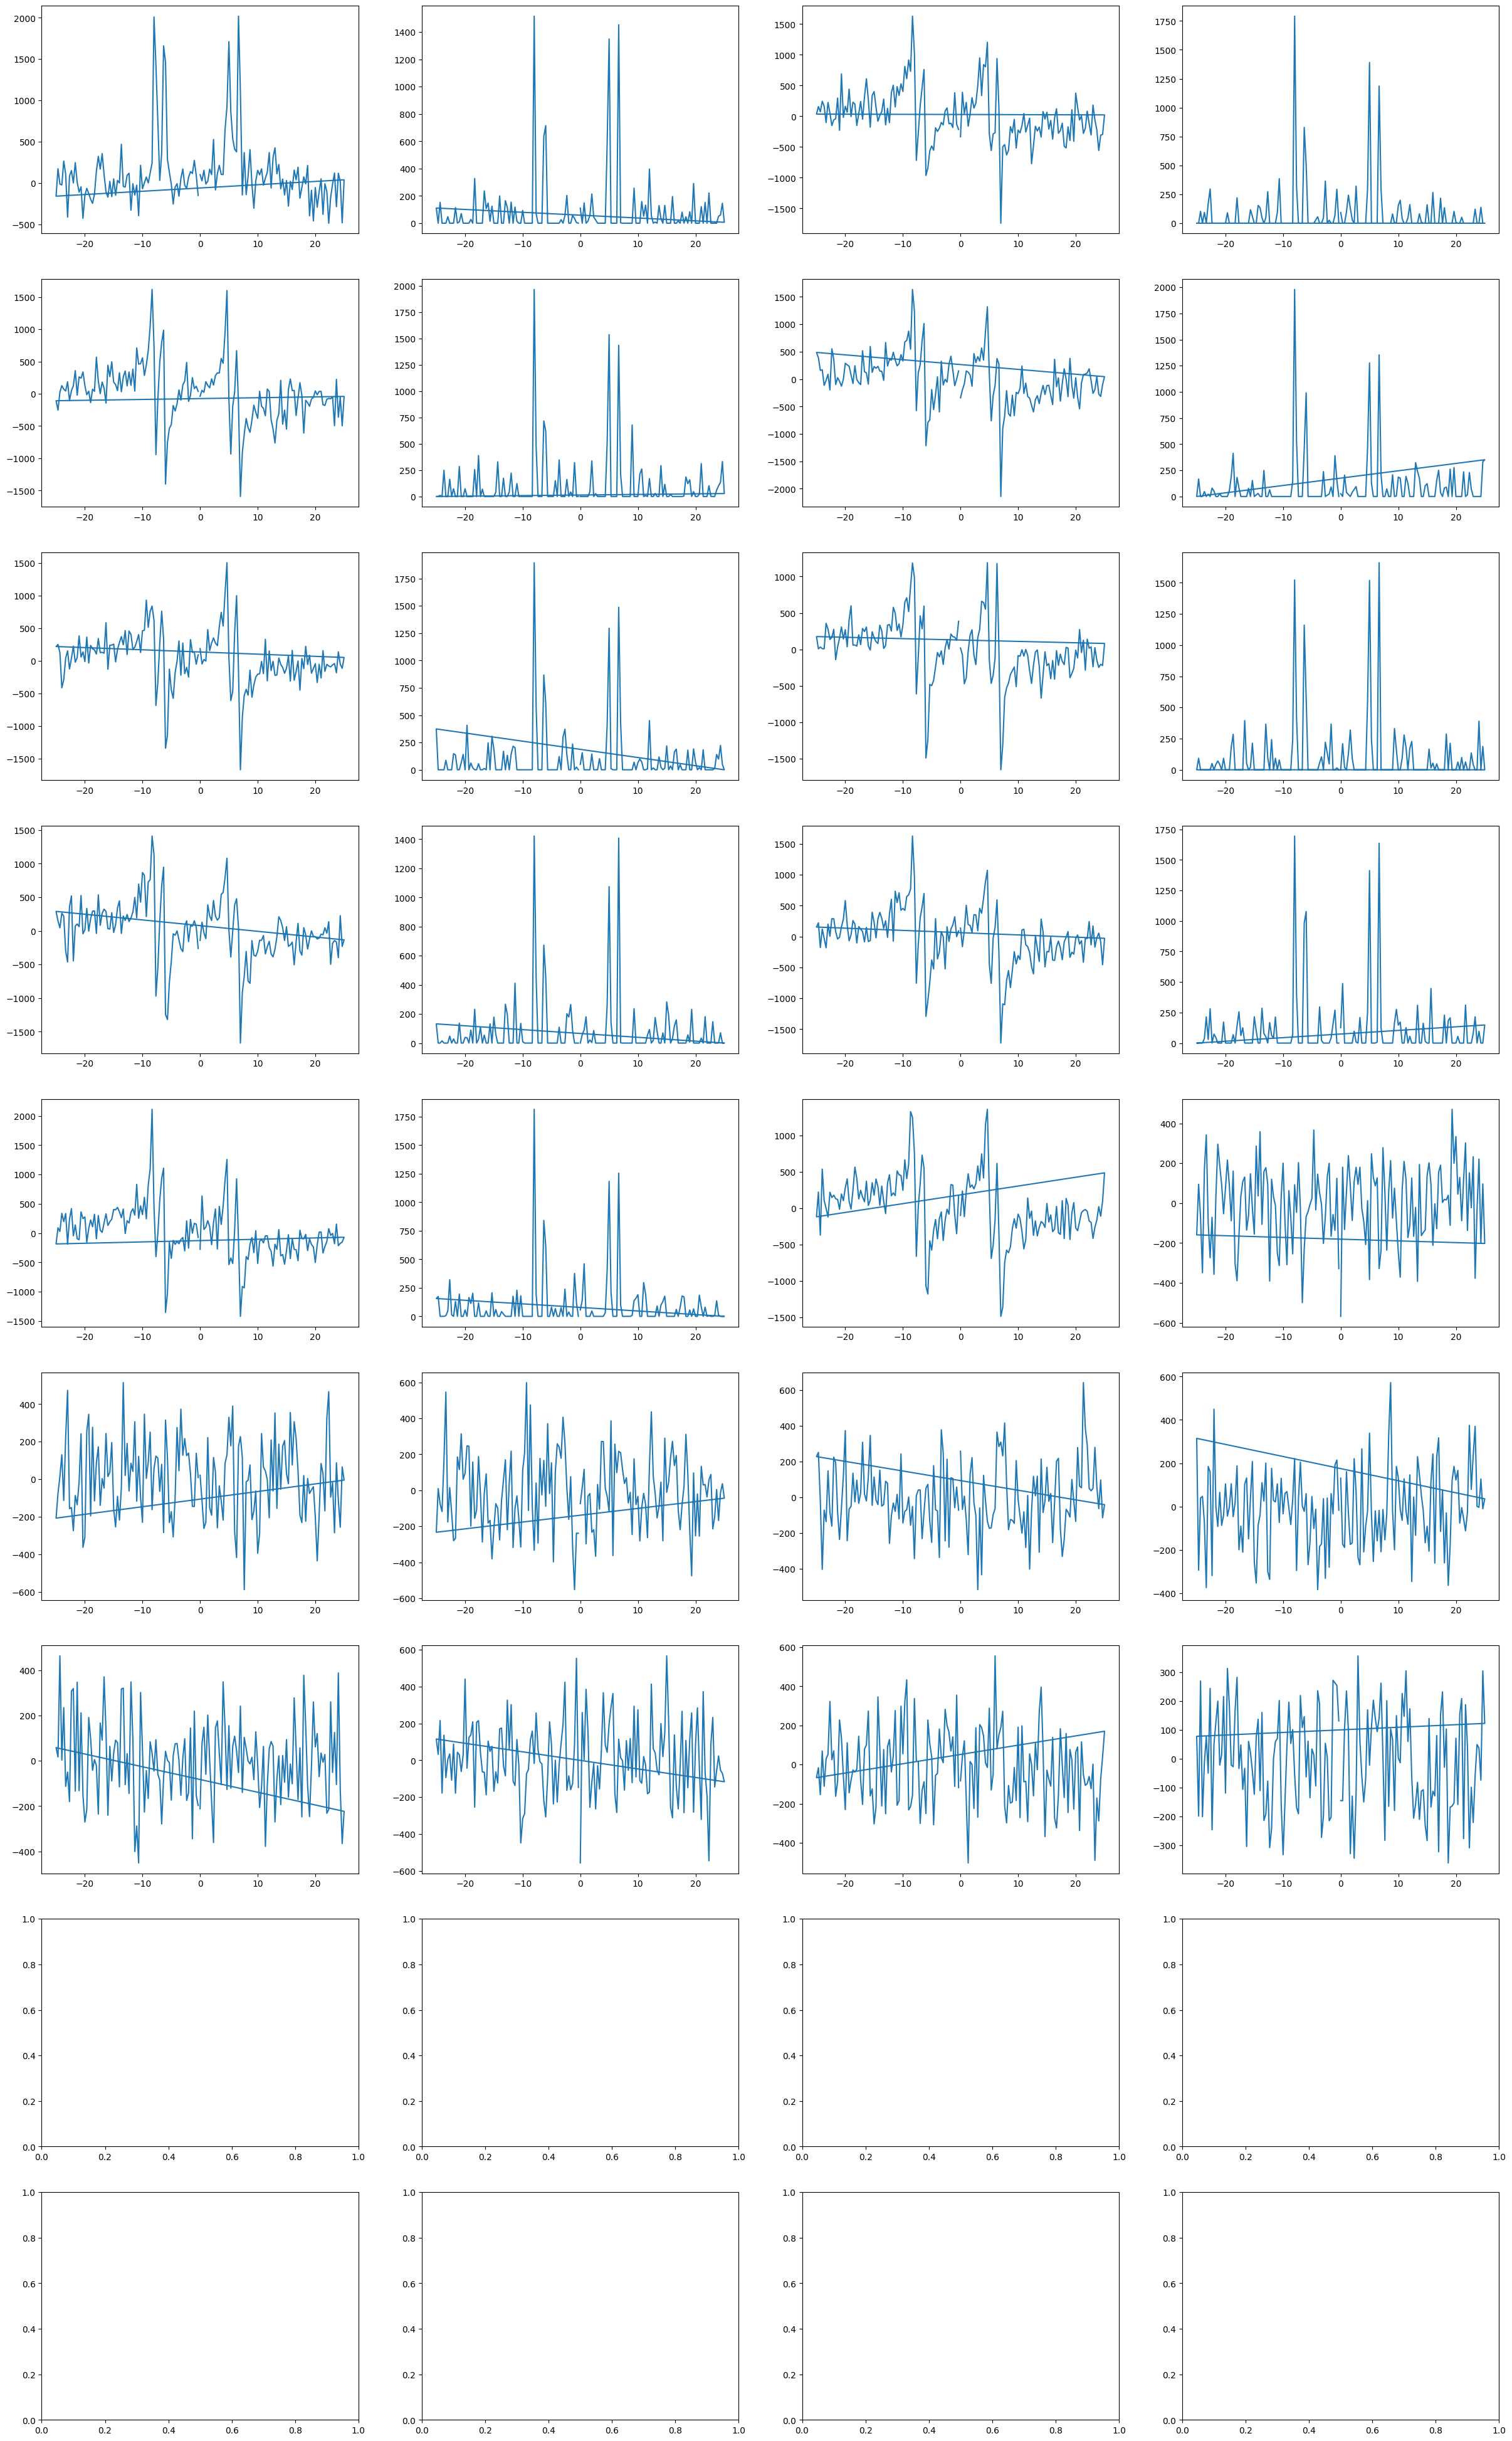

In [4]:
fig, axs = plt.subplots(9, 4, figsize=(30, 50))
axs = axs.flatten()
for idx in range(ss.size[1]):
    axs[idx].plot(ss.freqs[2], np.real(ss.spectras[2][idx]))
plt.show()

In [5]:
type(None)

NoneType

Optimization terminated successfully.
         Current function value: 1062.591951
         Iterations: 96
         Function evaluations: 182


IndexError: index 24 is out of bounds for axis 0 with size 24

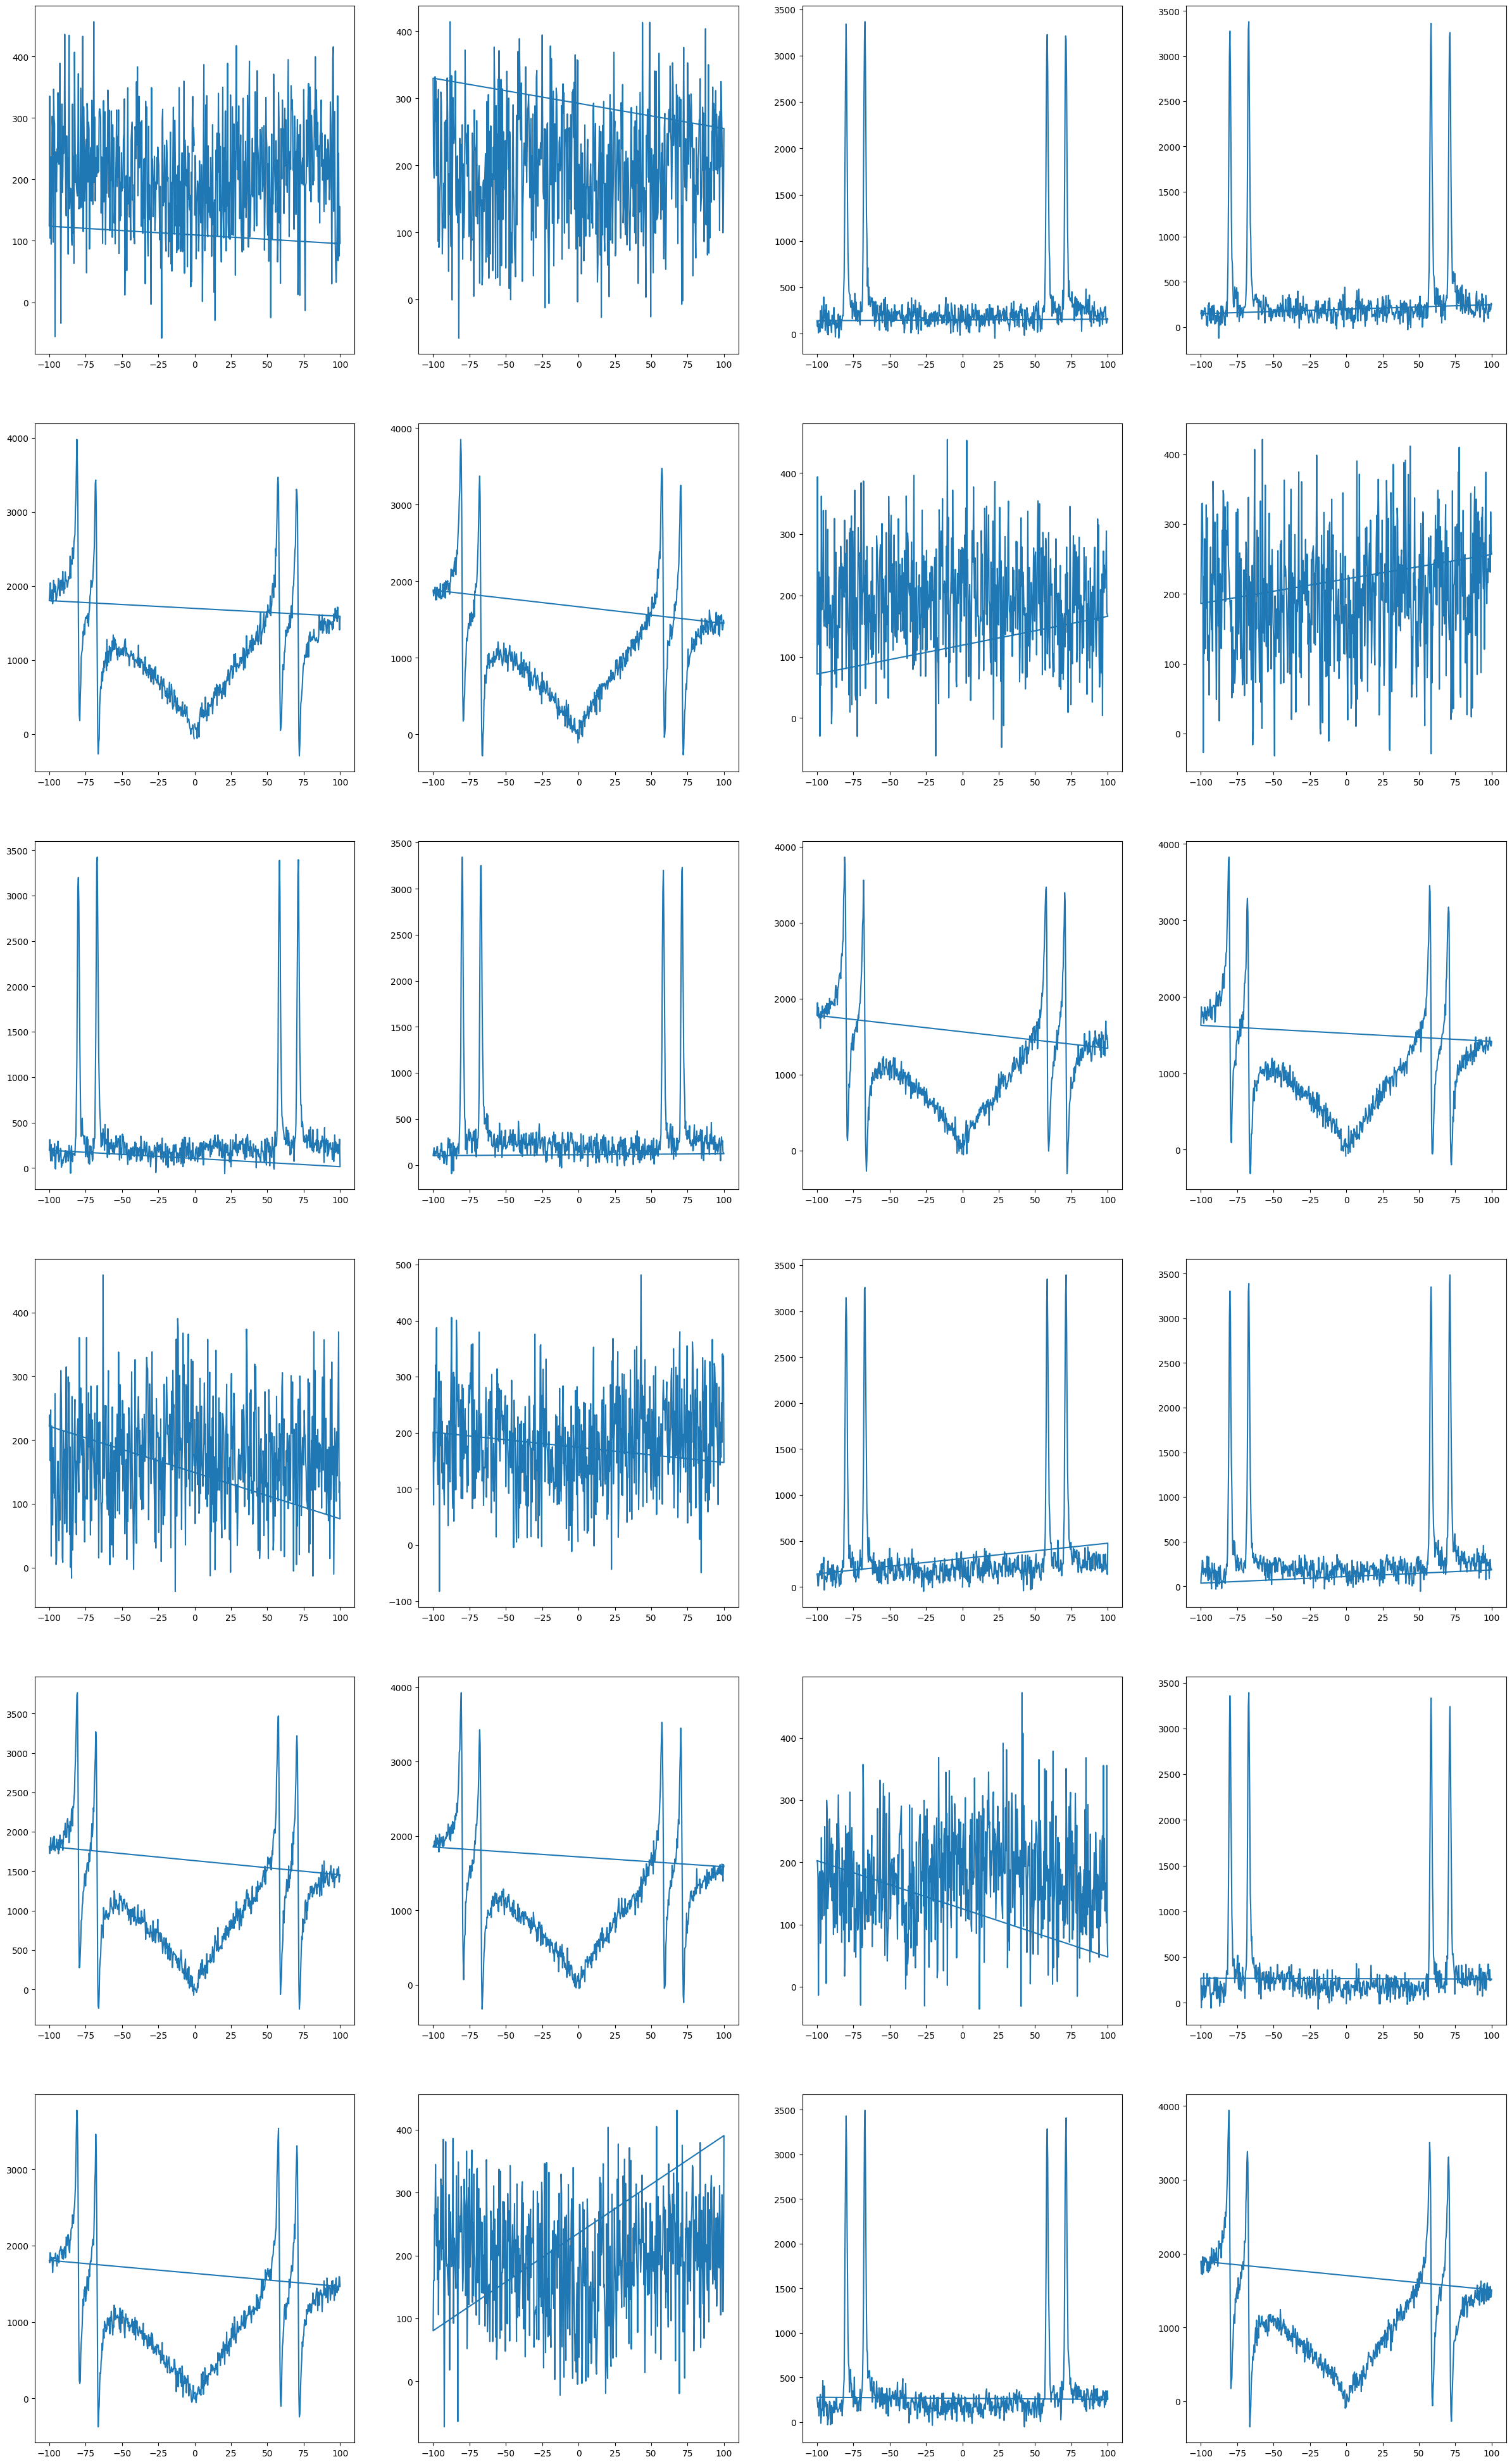

In [6]:
from scipy import signal

def proper_phases(data, window):
    spectrum_unpr = np.fft.fft(window * data[0])
    spectrum, phases = ng.proc_autophase.autops(spectrum_unpr, 'acme', return_phases=True)
    return phases

def noize_spectra_idx(data):
    max_vals = []
    for i in range(len(data)):
        spectrum_unpr = np.fft.fft(data[i])
        maxima = max(np.real(spectrum_unpr))
        max_vals.append(maxima)
    threshold = np.mean(maxima) / 100
    indices = [i for i, value in enumerate(max_vals) if value < threshold]
    return indices



tn = 'C' # Название исследуемого ядра

dic, data = ng.varian.read(r'test//C')
df = pd.read_csv('test//dict.csv')
filtered_df = df[df['nucleus'] == 'C']
at = float(dic['procpar']['at']['values'][0])
peak_width = filtered_df['peak_width'].values[0]
center = filtered_df['center'].values[0]
region = filtered_df['borders'].values[0]

window = 1
phases = proper_phases(data, window)
id_idx = noize_spectra_idx(data)
n = len(data[0])
time = np.linspace(0, at, n)
dt = at / n

frequencies = np.fft.fftfreq(n, d=dt)
dnu = frequencies[1] - frequencies[0]
peak_idx_width = int(peak_width / dnu)
mask = (frequencies >= center-region) & (frequencies <= center+region)
frequencies = frequencies[mask]

integrated_areas = []
fig, axs = plt.subplots(6, 4, figsize=(30, 50))
axs = axs.flatten()
spectras = []
peaks = []

for idx in range(len(data)):
    if idx not in id_idx and idx != 0:
        spectrum = np.fft.fft(window * (data[idx]))[mask]
        ph_corrected_spectrum = np.real(spectrum * np.exp(1j * 2 * np.pi / 360 * (phases[0])))
        normalized_spectrum = ph_corrected_spectrum / max(ph_corrected_spectrum)
        bl = baseline(ph_corrected_spectrum, 3)
        corrected_spectrum = ph_corrected_spectrum - bl
        loc_peaks = ng.analysis.peakpick.pick(normalized_spectrum, 0.3, -0.3, table=True)
        iter = 1
        area_indices = []
        for peak in loc_peaks:
            left = int(peak[0] - peak_idx_width)
            right = int(peak[0] + peak_idx_width)
            # area = simps(np.real(ph_corrected_spectrum[left:right]), frequencies[left:right])
            # integrated_areas.append([{'index':idx + 1}, {'integral_num': iter}, {'area':area}])
            iter += 1
        peaks.append(loc_peaks)
        spectras.append(corrected_spectrum)

for idx in range(len(spectras)):
    axs[idx].plot(frequencies, spectras[idx])
    for i in range(len(peaks[idx])):
        s = int(peaks[idx][i][0] + peak_idx_width)
        p = int(peaks[idx][i][0] - peak_idx_width)
        # axs[idx].axvline(x=frequencies[s], color='orange', linestyle='--')
        # axs[idx].axvline(x=frequencies[p], color='blue', linestyle='--')
plt.show()